Recreating the tutorial jupyter nb from the RipsNet github

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataloader import default_collate

import time
import math

from ripsnet import RipsNet
from datasets.dataset_utils import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
import gudhi as gd
from gudhi.representations import DiagramSelector
from gudhi.representations import Landscape, PersistenceImage

In [2]:
# Looks like there's a bug in gudhi 3.8.0 that prevents the PI bounds from being set properly in 
# PI_train = PersistenceImage(**PI_params).transform(pds_train)
# Gudhi 3.6.0 works fine though.
print(gd.__version__)

3.6.0


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_seed = 42
device

device(type='cuda', index=0)

In [4]:
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'


In [5]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

In [6]:
data_train, label_train = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)
clean_data_test, clean_label_test = create_multiple_circles(N_sets_test, N_points, noisy=0, N_noise=N_noise)
noisy_data_test, noisy_label_test = create_multiple_circles(N_sets_test, N_points, noisy=1, N_noise=N_noise)

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 135.83it/s]


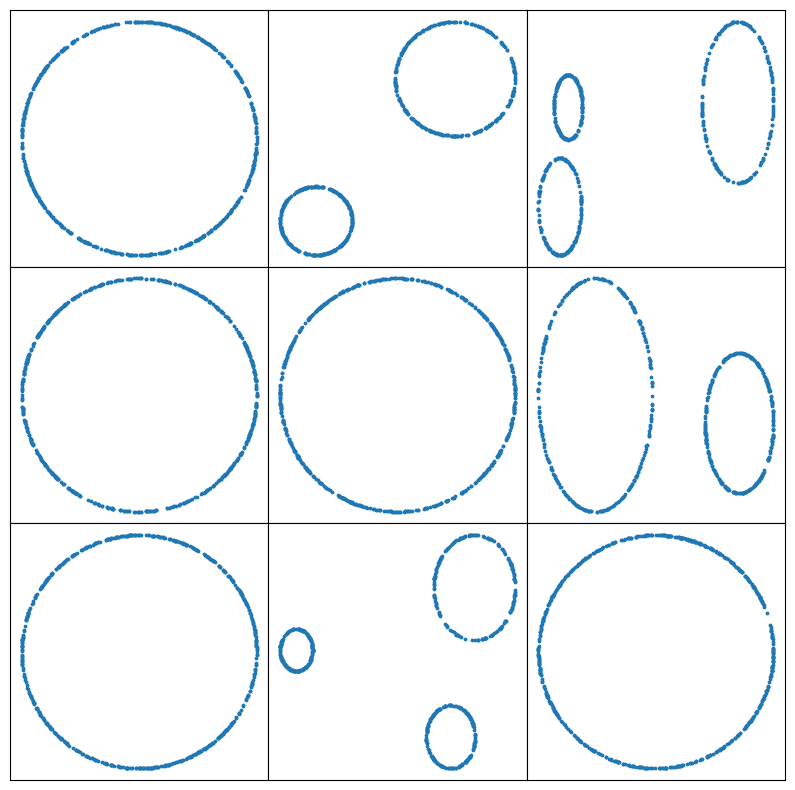

In [7]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

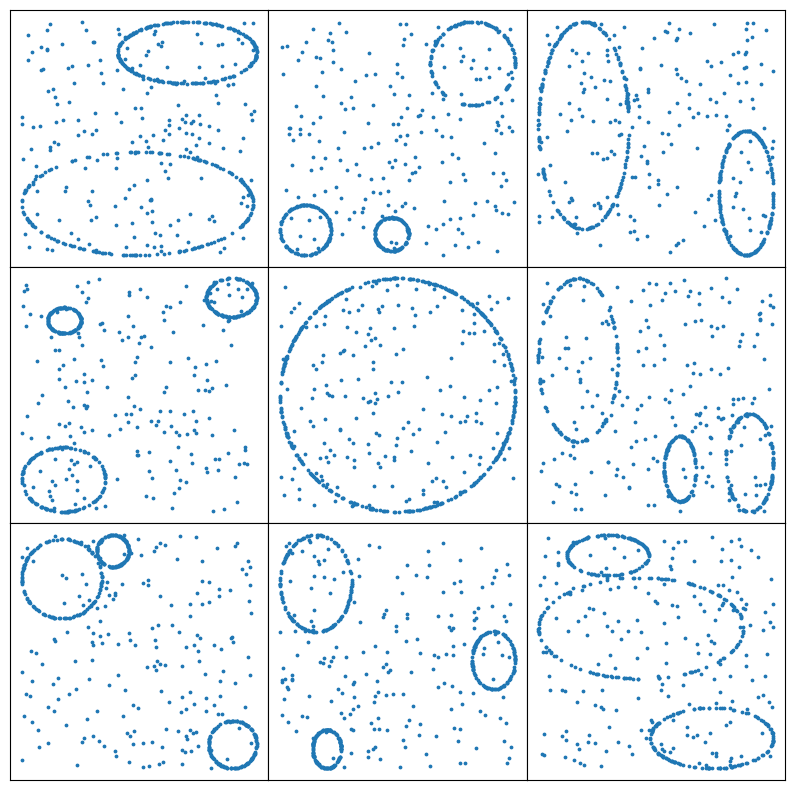

In [8]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

In [9]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

In [10]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

In [11]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)
    
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)
    
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|█████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 151.95it/s]


In [12]:
PVs_train, clean_PVs_test, noisy_PVs_test, PVs_params = [], [], [], []
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

In [13]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

In [14]:
PI_params = {'bandwidth': sigma, 'weight': lambda x: 10*np.tanh(x[1]), 
             'resolution': [50,50], 'im_range': im_bnds}
PI_train = PersistenceImage(**PI_params).transform(pds_train)
clean_PI_test = PersistenceImage(**PI_params).transform(clean_pds_test)
noisy_PI_test = PersistenceImage(**PI_params).transform(noisy_pds_test)
MPI = np.max(PI_train)
PI_train /= MPI
clean_PI_test /= MPI
noisy_PI_test /= MPI

Lets create our torch datasets

In [15]:
PI_train = torch.Tensor(PI_train)
clean_PI_test = torch.Tensor(clean_PI_test)
noisy_PI_test = torch.Tensor(noisy_PI_test)

data_train = torch.Tensor(np.array(data_train))
clean_data_test= torch.Tensor(np.array(clean_data_test))
noisy_data_test = torch.Tensor(np.array(noisy_data_test))

In [16]:
len(data_train)

900

In [17]:
train_dataset = TensorDataset(data_train, PI_train)
clean_test_dataset = TensorDataset(clean_data_test, clean_PI_test)
noisy_test_dataset = TensorDataset(noisy_data_test, noisy_PI_test)

In [18]:
generator = torch.Generator().manual_seed(random_seed)
split_fracs = [0.9, 0.1, 0]
split_lens = [int(frac * len(train_dataset)) for frac in split_fracs]

train_dataset, valid_dataset, _ = torch.utils.data.random_split(train_dataset, split_lens, generator = generator) 

In [19]:
train_dataloader = DataLoader(train_dataset, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])
valid_dataloader = DataLoader(valid_dataset, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])
clean_dataset = DataLoader(clean_test_dataset, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])
noisy_dataset = DataLoader(noisy_test_dataset, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])

In [20]:
model = RipsNet()

In [21]:
opt = torch.optim.Adamax(model.parameters(), lr=5e-4)
loss_fn_mae = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()

In [22]:
run_name = 'nb_model_20230626'
print(run_name)

nb_model_20230626


In [23]:
print(device)
model.to(device)

cuda:0


RipsNet(
  (rips_net): Sequential(
    (0): DeepSetLayer()
    (1): ReLU()
    (2): DeepSetLayer()
    (3): ReLU()
    (4): DeepSetLayer()
    (5): ReLU()
    (6): DeepSetSum()
    (7): Linear(in_features=10, out_features=50, bias=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=200, bias=True)
    (10): ReLU()
    (11): Linear(in_features=200, out_features=2500, bias=True)
    (12): Sigmoid()
  )
)

In [41]:
def evaluate(model, dataloader, loss_fn, loss_fn_mae, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, dat in enumerate(dataloader):
            output = model(dat[0])
            loss = loss_fn(output, dat[1]).cpu()
            loss_mae = loss_fn_mae(output, dat[1]).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative/len(dataloader), loss_cumulative_mae/len(dataloader)

In [48]:
def train(model, optimizer, dataloader_train, dataloader_valid, loss_fn, run_name, 
          scheduler=None, device="cuda"):
    
    model.to(device)
    run_name = 'nb_model_20230626'
    checkpoint_generator = loglinspace(0.3, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()
    
    try: model.load_state_dict(torch.load(run_name + '.torch')['state'])
    except:
        results = {}
        history = []
        s0 = 0
    else:
        results = torch.load(run_name + '.torch')
        history = results['history']
        s0 = history[-1]['step'] + 1

    max_iter = 100
    for step in range(max_iter):
        model.train()
        loss_cumulative = 0.
        loss_cumulative_mae = 0.
        
        for ind, dat in tqdm(enumerate(dataloader_train), total=len(dataloader_train), bar_format=bar_format):
            output = model(dat[0])
            loss = loss_fn(output, dat[1]).cpu()
            loss_mae = loss_fn_mae(output, dat[1]).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()
        wall = end_time - start_time

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step

            valid_avg_loss = evaluate(model, dataloader_valid, loss_fn, loss_fn_mae, device)
            train_avg_loss = evaluate(model, dataloader_train, loss_fn, loss_fn_mae, device)

            history.append({
                'step': s0 + step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'mean_abs': loss_mae.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'mean_abs': valid_avg_loss[1],
                },
                'train': {
                    'loss': train_avg_loss[0],
                    'mean_abs': train_avg_loss[1],
                },
            })

            results = {
                'history': history,
                'state': model.state_dict()
            }

            print(f"Iteration {step+1:4d}   " +
                  f"train loss = {train_avg_loss[0]:8.4f}   " +
                  f"valid loss = {valid_avg_loss[0]:8.4f}   " +
                  f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}")

            with open(run_name + '.torch', 'wb') as f:
                torch.save(results, f)

        #if scheduler is not None:
            #scheduler.step()

In [49]:
def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step*(1 - math.exp(-t*rate/step)))

In [50]:
train(model, opt, train_dataloader, valid_dataloader, loss_fn, loss_fn_mae, run_name, device=device)

100%|██████████| 810/810 [00:02<00:00, 300.36it/s]                                                                           


Iteration    1   train loss =   0.0018   valid loss =   0.0034   elapsed time = 00:00:02


100%|██████████| 810/810 [00:02<00:00, 313.00it/s]                                                                           


Iteration    2   train loss =   0.0015   valid loss =   0.0035   elapsed time = 00:00:05


100%|██████████| 810/810 [00:02<00:00, 311.91it/s]                                                                           


Iteration    3   train loss =   0.0009   valid loss =   0.0031   elapsed time = 00:00:09


100%|██████████| 810/810 [00:02<00:00, 312.43it/s]                                                                           


Iteration    4   train loss =   0.0007   valid loss =   0.0029   elapsed time = 00:00:12


100%|██████████| 810/810 [00:02<00:00, 313.92it/s]                                                                           


Iteration    5   train loss =   0.0006   valid loss =   0.0029   elapsed time = 00:00:15


100%|██████████| 810/810 [00:02<00:00, 308.20it/s]                                                                           


Iteration    7   train loss =   0.0005   valid loss =   0.0029   elapsed time = 00:00:21


100%|██████████| 810/810 [00:02<00:00, 307.15it/s]                                                                           


Iteration    9   train loss =   0.0004   valid loss =   0.0028   elapsed time = 00:00:27


100%|██████████| 810/810 [00:02<00:00, 307.21it/s]                                                                           


Iteration   11   train loss =   0.0003   valid loss =   0.0029   elapsed time = 00:00:33


100%|██████████| 810/810 [00:02<00:00, 307.13it/s]                                                                           


Iteration   14   train loss =   0.0003   valid loss =   0.0029   elapsed time = 00:00:42


100%|██████████| 810/810 [00:02<00:00, 307.73it/s]                                                                           


Iteration   17   train loss =   0.0002   valid loss =   0.0028   elapsed time = 00:00:50


100%|██████████| 810/810 [00:02<00:00, 306.62it/s]                                                                           


Iteration   21   train loss =   0.0002   valid loss =   0.0029   elapsed time = 00:01:02


100%|██████████| 810/810 [00:02<00:00, 293.87it/s]                                                                           


Iteration   25   train loss =   0.0001   valid loss =   0.0026   elapsed time = 00:01:13


100%|██████████| 810/810 [00:02<00:00, 293.44it/s]                                                                           


Iteration   29   train loss =   0.0001   valid loss =   0.0027   elapsed time = 00:01:25


100%|██████████| 810/810 [00:02<00:00, 292.80it/s]                                                                           


Iteration   34   train loss =   0.0003   valid loss =   0.0027   elapsed time = 00:01:40


100%|██████████| 810/810 [00:02<00:00, 291.79it/s]                                                                           


Iteration   39   train loss =   0.0001   valid loss =   0.0027   elapsed time = 00:01:54


100%|██████████| 810/810 [00:02<00:00, 293.20it/s]                                                                           


Iteration   44   train loss =   0.0001   valid loss =   0.0027   elapsed time = 00:02:09


100%|██████████| 810/810 [00:02<00:00, 291.66it/s]                                                                           


Iteration   49   train loss =   0.0001   valid loss =   0.0028   elapsed time = 00:02:23


100%|██████████| 810/810 [00:02<00:00, 292.03it/s]                                                                           


Iteration   54   train loss =   0.0001   valid loss =   0.0029   elapsed time = 00:02:38


100%|██████████| 810/810 [00:02<00:00, 294.19it/s]                                                                           


Iteration   59   train loss =   0.0001   valid loss =   0.0028   elapsed time = 00:02:52


100%|██████████| 810/810 [00:02<00:00, 293.61it/s]                                                                           


Iteration   64   train loss =   0.0000   valid loss =   0.0027   elapsed time = 00:03:07


100%|██████████| 810/810 [00:02<00:00, 293.86it/s]                                                                           


Iteration   69   train loss =   0.0001   valid loss =   0.0026   elapsed time = 00:03:21


100%|██████████| 810/810 [00:02<00:00, 295.80it/s]                                                                           


Iteration   74   train loss =   0.0000   valid loss =   0.0028   elapsed time = 00:03:36


100%|██████████| 810/810 [00:02<00:00, 295.03it/s]                                                                           


Iteration   79   train loss =   0.0000   valid loss =   0.0028   elapsed time = 00:03:50


100%|██████████| 810/810 [00:02<00:00, 294.22it/s]                                                                           


Iteration   84   train loss =   0.0000   valid loss =   0.0029   elapsed time = 00:04:05


100%|██████████| 810/810 [00:02<00:00, 294.10it/s]                                                                           


Iteration   89   train loss =   0.0000   valid loss =   0.0028   elapsed time = 00:04:19


100%|██████████| 810/810 [00:02<00:00, 293.84it/s]                                                                           


Iteration   94   train loss =   0.0000   valid loss =   0.0028   elapsed time = 00:04:34


100%|██████████| 810/810 [00:02<00:00, 293.24it/s]                                                                           


Iteration   99   train loss =   0.0000   valid loss =   0.0027   elapsed time = 00:04:48


100%|██████████| 810/810 [00:02<00:00, 292.01it/s]                                                                           


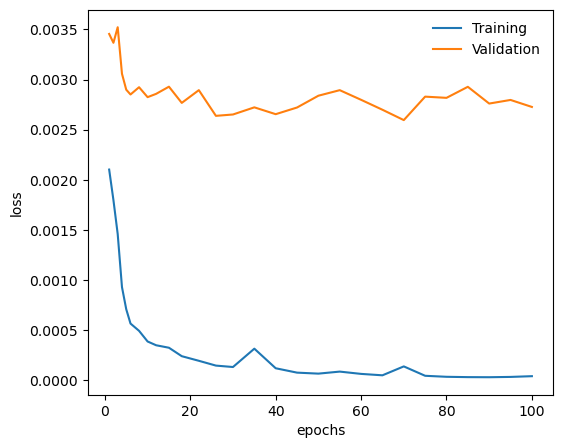

In [53]:
history = torch.load('./nb_model_20230626.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, label="Training")
ax.plot(steps, loss_valid, label="Validation")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);
plt.savefig('./nb_model_20230626.svg')

In [55]:
evaluate(model, clean_dataset, loss_fn, loss_fn_mae, device)

(0.003893520230546888, 0.018549979605401556)

In [100]:
def make_predictions(model, dataloader, device):
    model.to(device)
    model.eval()
    preds = []
    #preds = np.zeros(shape = (len(dataloader), 2500))
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            output = model(d[0])
            output = torch.nan_to_num(output)
            #output.cpu()
            #preds[j] = output
            preds.append(output.cpu())
    return preds

In [105]:
train_PI_prediction = np.array(make_predictions(model, train_dataloader, device))
clean_PI_prediction = np.array(make_predictions(model, clean_dataset, device))
noisy_PI_prediction = np.array(make_predictions(model, noisy_dataset, device))

/tmp/ipykernel_657764/324198324.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_PI_prediction = np.array(make_predictions(model, train_dataloader, device))
/tmp/ipykernel_657764/324198324.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_PI_prediction = np.array(make_predictions(model, train_dataloader, device))
/tmp/ipykernel_657764/324198324.py:2

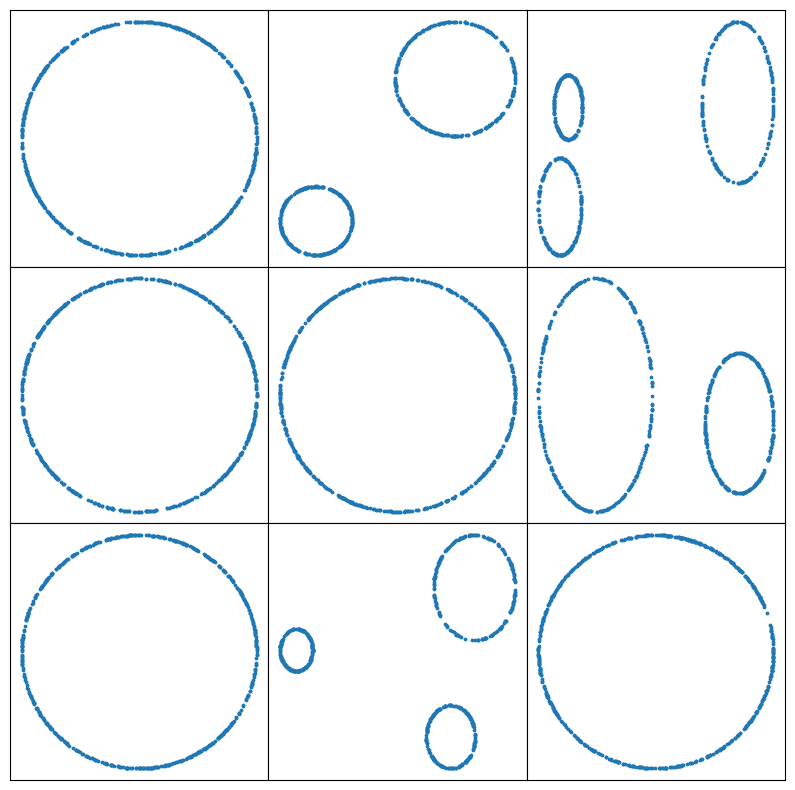

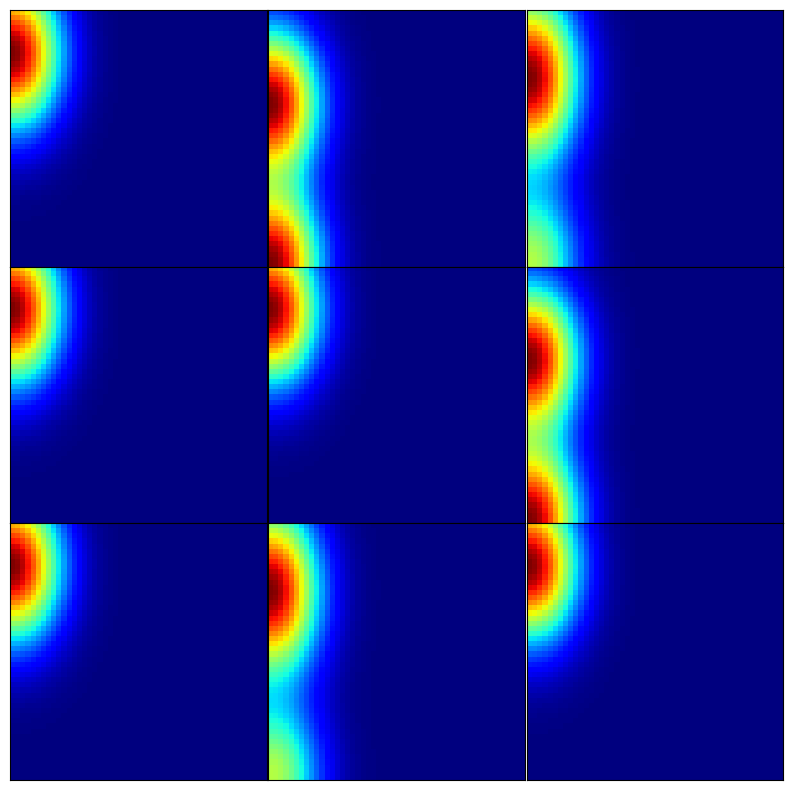

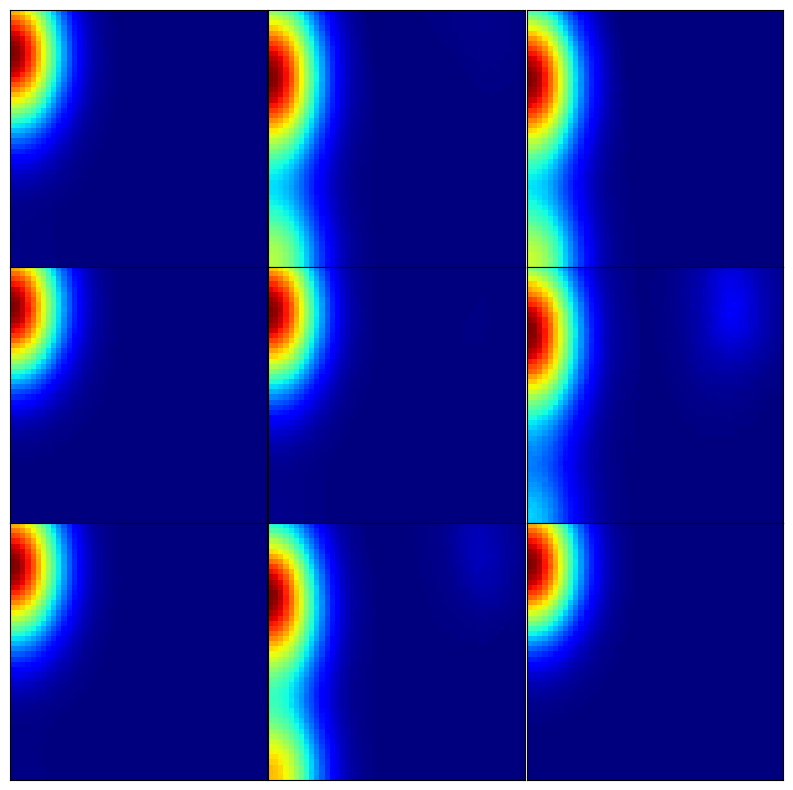

In [116]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j,:,0], clean_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.reshape(clean_PI_test[3*i+j], [50,50]), cmap='jet')
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.reshape(clean_PI_prediction[3*i+j], [50,50]), cmap='jet')
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

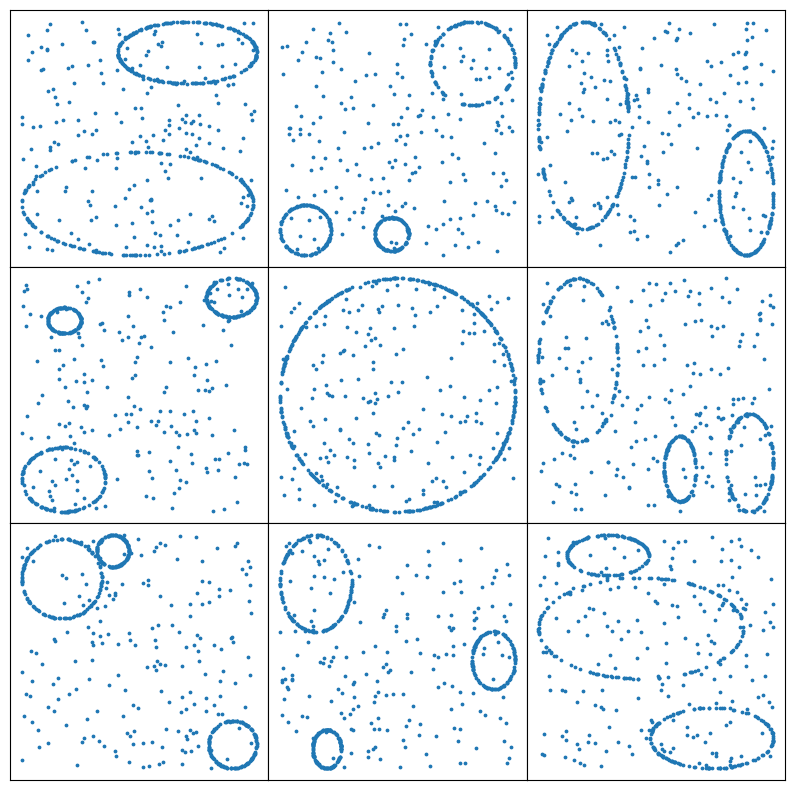

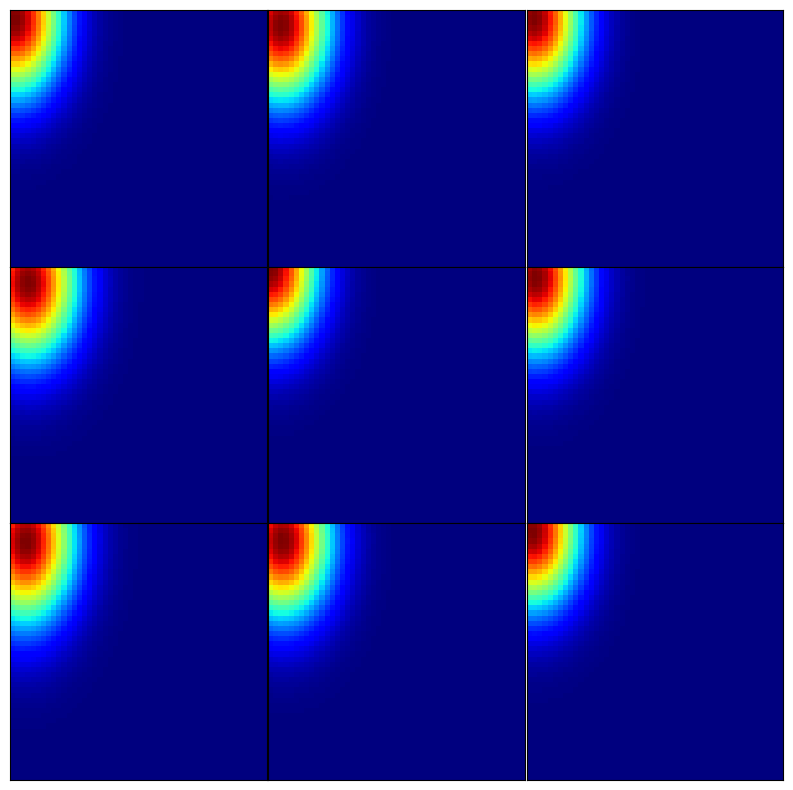

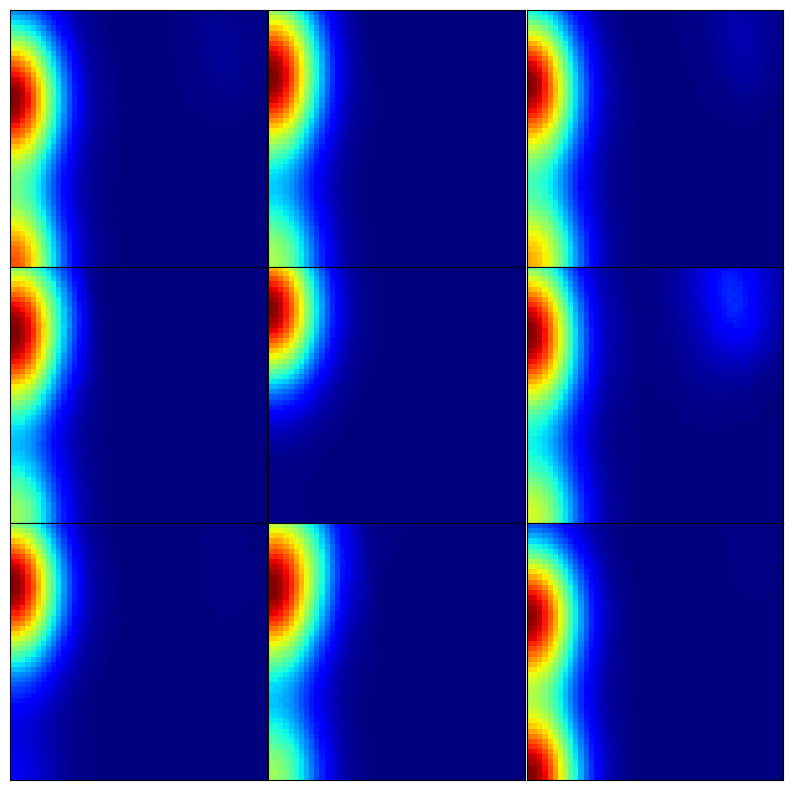

In [120]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j,:,0], noisy_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.reshape(noisy_PI_test[3*i+j], [50,50]), cmap='jet')
        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()
plt.savefig('noisy_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.reshape(noisy_PI_prediction[3*i+j], [50,50]), cmap='jet')
        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()
plt.savefig('noisy_ripsnet_pi.png', bbox_inches='tight')